# Quantazation Theory

In machine learning, the basic cycle is divided into two main phases:

Training: Adjusting the model parameters.
- Data + labels
- Forward pass
- Loss calculation
- Backpropagation
- Updating weights (SGD, Adam, etc.)

Inference: This is when the model is used.
- Only forward pass
- No gradients
- No weight updates

Let's walk through the inference part. In practice, during quantized inference, dequantization does not occur between operations. Multiplications are performed in INT8 with accumulation in INT32, because although the product of two INT8s fits in INT16, the sum of hundreds or thousands of these products does not. Using INT32 as an accumulator avoids overflow and preserves performance.

## Pure Mathematical

### Libraries

In [ ]:
import os
import time
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Any

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

### Quantization Operators

#### Per Tensor

##### Symmetric

In [2]:
def linear_symmetric_quantize(
    tensor: np.ndarray, 
    scale: float,
    dtype: np.dtype = np.int8,
    mode: str = 'round') -> np.ndarray:
    
    tensor_fp = tensor.astype(np.float32)

    if mode == 'round':
        q = np.round(tensor_fp / scale)
    elif mode == 'truncate':
        q = np.fix(tensor_fp / scale)
    else:
        raise ValueError("mode should be 'round' or 'truncate'")
    
    qmin = -np.iinfo(dtype).max
    qmax = np.iinfo(dtype).max
    q = np.clip(q, qmin, qmax)

    return q.astype(dtype)

def linear_symmetric_dequantize(q_tensor: np.ndarray, scale: float) -> np.ndarray:
    return q_tensor.astype(np.float32) * scale

def get_q_scale(tensor: np.ndarray, dtype: np.dtype = np.int8):
    q_max = np.iinfo(dtype).max
    r_max_abs = np.max(np.abs(tensor))
    
    if r_max_abs < 1e-9:
        return 1.0
    
    scale = r_max_abs / q_max
    
    return float(scale)

def calculate_quantization_error(original: np.ndarray, dequantized: np.ndarray):
    mse = np.mean((original - dequantized) ** 2)
    
    signal_power = np.mean(original ** 2)
    noise_power = mse
    if noise_power == 0:
        return mse, float('inf')
    
    snr = 10 * np.log10(signal_power / noise_power)
    return mse, snr

##### Asymmetric

In [ ]:
def linear_asymmetric_quantize(
    tensor: np.ndarray, 
    scale: float, 
    zero_point: int, 
    dtype: np.dtype = np.int8,
    mode: str = 'round') -> np.ndarray:
    
    tensor_fp = tensor.astype(np.float32)
    
    if mode == 'round':
        q = np.round(tensor_fp / scale + zero_point)
    elif mode == 'truncate':
        q = np.fix(tensor_fp / scale + zero_point)
    else:
        raise ValueError("mode should be 'round' or 'truncate'")

    qmin = np.iinfo(dtype).min
    qmax = np.iinfo(dtype).max
    q = np.clip(q, qmin, qmax)

    return q.astype(dtype)

def linear_asymmetric_dequantize(q_tensor: np.ndarray, scale: float, zero_point: int) -> np.ndarray:
    return (q_tensor.astype(np.float32) - zero_point) * scale

def get_q_scale_and_zero_point(tensor: np.ndarray, dtype: np.dtype = np.int8, mode: str = 'round'):
    q_min = np.iinfo(dtype).min
    q_max = np.iinfo(dtype).max
    
    r_min = tensor.min()
    r_max = tensor.max()
    
    scale = (r_max - r_min) / (q_max - q_min)
    
    if scale == 0:
        scale = 1e-8
    
    zero_point = q_min - (r_min / scale)
    if mode == 'round':
        zero_point = np.clip(np.round(zero_point), q_min, q_max).astype(dtype)
    elif mode == 'truncate':
        zero_point = np.clip(np.fix(zero_point), q_min, q_max).astype(dtype)
    else:
        raise ValueError("mode should be 'round' or 'truncate'")
        
    return float(scale), zero_point

##### Evaluation

In [8]:
x = np.array([-5.0, -2.5, 0, 2.5, 5.0], dtype=np.float32)

print("Symmetric Evaluation")
print('###'*10)
s = get_q_scale(x, np.int8)

mode = 'truncate'
q = linear_symmetric_quantize(x, s, np.int8, mode)
x_hat = linear_symmetric_dequantize(q, s)
mse_s, snr_s = calculate_quantization_error(x, x_hat)

print(f"Mode: {mode.upper()}")
print(f"Original: {x}")
print(f"Quantized: {q}")
print(f"Reconstructed: {x_hat}")
print(f"Symmetric -> MSE: {mse_s:.6f} | SNR: {snr_s:.2f} dB")

mode = 'round'
q = linear_symmetric_quantize(x, s, np.int8, mode)
x_hat = linear_symmetric_dequantize(q, s)
mse_s, snr_s = calculate_quantization_error(x, x_hat)

print('---'*10)
print(f"Mode: {mode.upper()}")
print(f"Quantized: {q}")
print(f"Reconstructed: {x_hat}")
print(f"Symmetric -> MSE: {mse_s:.6f} | SNR: {snr_s:.2f} dB")

print('\n'+"Asymmetric Evaluation")
print('###'*10)

mode = 'truncate'
scale, zp = get_q_scale_and_zero_point(x, np.int8, mode)
q = linear_asymmetric_quantize(x, scale, zp, np.int8, mode)
x_hat = linear_asymmetric_dequantize(q, scale, zp)
mse_t, snr_t = calculate_quantization_error(x, x_hat)

print(f"Mode: {mode.upper()}")
print(f"Original: {x}")
print(f"Quantized: {q}")
print(f"Reconstructed: {x_hat}")
print(f"MSE: {mse_t:.6f} | SNR: {snr_t:.2f} dB")

mode = 'round'
scale, zp = get_q_scale_and_zero_point(x, np.int8, mode)
q = linear_asymmetric_quantize(x, scale, zp, np.int8, mode)
x_hat = linear_asymmetric_dequantize(q, scale, zp)
mse_r, snr_r = calculate_quantization_error(x, x_hat)

print('\n' + '---' * 10)
print(f"Mode: {mode.upper()}")
print(f"Quantized: {q}")
print(f"Reconstructed: {x_hat}")
print(f"MSE: {mse_r:.6f} | SNR: {snr_r:.2f} dB")

Symmetric Evaluation
##############################
Mode: TRUNCATE
Original: [-5.  -2.5  0.   2.5  5. ]
Quantized: [-127  -63    0   63  127]
Reconstructed: [-5.       -2.480315  0.        2.480315  5.      ]
Symmetric -> MSE: 0.000155 | SNR: 49.07 dB
------------------------------
Mode: ROUND
Quantized: [-127  -64    0   64  127]
Reconstructed: [-5.       -2.519685  0.        2.519685  5.      ]
Symmetric -> MSE: 0.000155 | SNR: 49.07 dB

Asymmetric Evaluation
##############################
Mode: TRUNCATE
Original: [-5.  -2.5  0.   2.5  5. ]
Quantized: [-127  -63    0   63  127]
Reconstructed: [-4.9803925 -2.4705882  0.         2.4705882  4.9803925]
MSE: 0.000500 | SNR: 43.98 dB

------------------------------
Mode: ROUND
Quantized: [-128  -65   -1   63  126]
Reconstructed: [-4.9803925 -2.509804   0.         2.509804   4.9803925]
MSE: 0.000192 | SNR: 48.13 dB


#### Per Channel

##### Symmetric

In [ ]:
def linear_symmetric_quantize_per_channel(
    tensor: np.ndarray, 
    scales: np.ndarray,
    axis: int = 0,
    dtype: np.dtype = np.int8,
    mode: str = 'round') -> np.ndarray:
    
    broadcast_shape = [1] * tensor.ndim
    broadcast_shape[axis] = -1
    s = scales.reshape(broadcast_shape)
    
    tensor_fp = tensor.astype(np.float32)

    if mode == 'round':
        q = np.round(tensor_fp / s)
    elif mode == 'truncate':
        q = np.fix(tensor_fp / s)
    else:
        raise ValueError("mode should be 'round' or 'truncate'")
    
    qmin = -np.iinfo(dtype).max
    qmax = np.iinfo(dtype).max
    q = np.clip(q, qmin, qmax)

    return q.astype(dtype)

def linear_symmetric_dequantize_per_channel(
    q_tensor: np.ndarray, 
    scales: np.ndarray,
    axis: int = 0) -> np.ndarray:
    
    broadcast_shape = [1] * q_tensor.ndim
    broadcast_shape[axis] = -1
    s = scales.reshape(broadcast_shape)
    
    return q_tensor.astype(np.float32) * s

def get_q_scale_per_channel(
    tensor: np.ndarray,
    axis: int = 0,
    dtype: np.dtype = np.int8):
          
    q_max = np.iinfo(dtype).max
    
    reduce_axes = tuple(i for i in range(tensor.ndim) if i != axis)
    r_max_abs = np.max(np.abs(tensor), axis=reduce_axes)
    
    scale = r_max_abs / q_max
    scale = np.where(scale < 1e-9, 1.0, scale)
    
    return scale

##### Asymmetric

In [10]:
def linear_asymmetric_quantize_per_channel(
    tensor: np.ndarray, 
    scales: np.ndarray, 
    zero_points: np.ndarray, 
    axis: int = 0,
    dtype: np.dtype = np.int8,
    mode: str = 'round') -> np.ndarray:
    
    broadcast_shape = [1] * tensor.ndim
    broadcast_shape[axis] = -1
    s = scales.reshape(broadcast_shape)
    zp = zero_points.reshape(broadcast_shape)
    
    tensor_fp = tensor.astype(np.float32)
    
    if mode == 'round':
        q = np.round(tensor_fp / s + zp)
    elif mode == 'truncate':
        q = np.fix(tensor_fp / s + zp)
    
    qmin, qmax = np.iinfo(dtype).min, np.iinfo(dtype).max
    return np.clip(q, qmin, qmax).astype(dtype)

def linear_asymmetric_dequantize_per_channel(
    q_tensor: np.ndarray, 
    scales: np.ndarray, 
    zero_points: np.ndarray,
    axis: int = 0) -> np.ndarray:
    
    broadcast_shape = [1] * q_tensor.ndim
    broadcast_shape[axis] = -1
    s = scales.reshape(broadcast_shape)
    zp = zero_points.reshape(broadcast_shape)
    
    return (q_tensor.astype(np.float32) - zp) * s

def get_q_scale_and_zero_point_per_channel(
    tensor: np.ndarray, 
    axis: int = 0, 
    dtype: np.dtype = np.int8, 
    mode: str = 'round'):
    
    q_min = np.iinfo(dtype).min
    q_max = np.iinfo(dtype).max
    
    reduce_axes = tuple(i for i in range(tensor.ndim) if i != axis)
    r_min = tensor.min(axis=reduce_axes)
    r_max = tensor.max(axis=reduce_axes)
    
    scale = (r_max - r_min) / (q_max - q_min)
    scale = np.where(scale == 0, 1e-8, scale)
    
    zp = q_min - (r_min / scale)
    
    if mode == 'round':
        zp = np.round(zp)
    elif mode == 'truncate':
        zp = np.fix(zp)
    else:
        raise ValueError("mode should be 'round' or 'truncate'")
        
    zero_point = np.clip(zp, q_min, q_max).astype(dtype)
    
    return scale, zero_point

### Real Test

C:\Users\joaov_zm1q2wh\AppData\Local\Temp\ipykernel_22420\3378093737.py:67: RuntimeWarning: overflow encountered in exp
  elif isinstance(layer, nn.Sigmoid): curr = 1 / (1 + np.exp(-curr))



RESULTADOS: PROBLEMA DA ESPIRAL (ALTA COMPLEXIDADE)
Method    mean      std
  INT8 0.99971 0.000624
  FP32 0.99970 0.000611
  INT4 0.92576 0.083602
  INT2 0.47581 0.136589

Gerando visualização da fronteira de decisão...


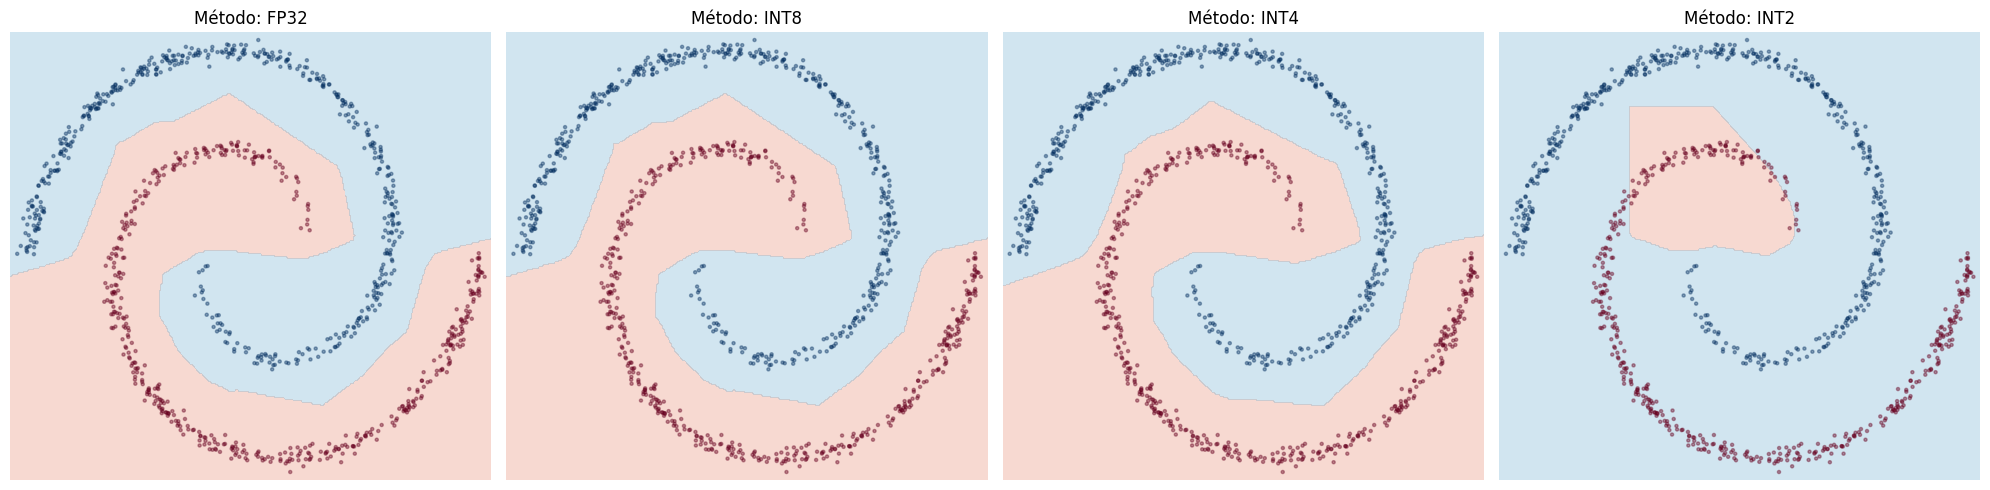

In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# --- 1. Definição do Modelo ---
class RobustMLP(nn.Module):
    def __init__(self, input_size=3, hidden_size=128):
        super(RobustMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.network(x)

# --- 2. Funções de Suporte e Quantização ---
def set_seed(seed=1):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def get_q_scale_nbits(tensor, bits=8):
    q_max = (2**(bits - 1)) - 1
    r_max_abs = np.max(np.abs(tensor))
    return float(r_max_abs / q_max) if r_max_abs > 1e-9 else 1.0

def linear_symmetric_quantize_nbits(tensor, scale, bits=8):
    q_min, q_max = -(2**(bits - 1)), (2**(bits - 1)) - 1
    q = np.round(tensor.astype(np.float32) / scale)
    return np.clip(q, q_min, q_max).astype(np.int8)

def linear_symmetric_dequantize(q_tensor, scale):
    return q_tensor.astype(np.float32) * scale

def generate_data(n=2500):
    theta = np.sqrt(np.random.rand(n)) * 2 * np.pi
    r1 = 2 * theta + np.pi
    x1 = np.array([r1 * np.cos(theta), r1 * np.sin(theta)]).T
    r2 = -2 * theta - np.pi
    x2 = np.array([r2 * np.cos(theta), r2 * np.sin(theta)]).T
    X = np.vstack([x1, x2])
    X += np.random.randn(*X.shape) * 0.3
    z_noise = np.random.normal(0, 0.1, (X.shape[0], 1))
    X = np.hstack([X, z_noise])
    y = np.hstack([np.zeros(n), np.ones(n)])
    idx = np.arange(len(X)); np.random.shuffle(idx)
    return torch.tensor(X[idx], dtype=torch.float32), torch.tensor(y[idx], dtype=torch.float32).view(-1,1)

def forward_sim_logic(x, weights, model):
    curr = x.numpy()
    l_idx = 0
    for layer in model.network:
        if isinstance(layer, nn.Linear):
            w = weights[f"network.{l_idx}.weight"]
            b = weights[f"network.{l_idx}.bias"]
            curr = np.dot(curr, w.T) + b
        elif isinstance(layer, nn.ReLU): curr = np.maximum(0, curr)
        elif isinstance(layer, nn.Sigmoid): curr = 1 / (1 + np.exp(-curr))
        l_idx += 1
    return torch.tensor(curr, dtype=torch.float32)

def plot_decision_boundaries(model, q_weights_dict, X, y):
    methods = list(q_weights_dict.keys())
    fig, axes = plt.subplots(1, len(methods), figsize=(20, 5))
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    grid_points = np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())]
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

    for i, m in enumerate(methods):
        out = forward_sim_logic(grid_tensor, q_weights_dict[m], model)
        Z = (out.reshape(xx.shape) > 0.5).numpy()
        axes[i].contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
        axes[i].scatter(X[:, 0], X[:, 1], c=y.flatten(), s=5, alpha=0.4, cmap='RdBu')
        axes[i].set_title(f"Método: {m}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# --- 3. Benchmark Principal ---
def run_hardcore_ensemble(num_runs=10):
    results = []
    seeds = range(100, 100 + num_runs)
    last_q_weights = {} # Para o plot final
    last_X, last_y = None, None

    for run, seed in enumerate(seeds):
        set_seed(seed)
        X, y = generate_data()
        split = int(0.8 * len(X))
        X_train, y_train = X[:split], y[:split]
        X_test, y_test = X[split:], y[split:]
        
        model = RobustMLP(input_size=3, hidden_size=16) # Aumentado levemente para a espiral
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        criterion = nn.BCELoss()

        for _ in range(300): # Espiral precisa de mais épocas
            optimizer.zero_grad()
            criterion(model(X_train), y_train).backward()
            optimizer.step()

        current_run_weights = {}
        configs = [('FP32', 32), ('INT8', 8), ('INT4', 4), ('INT2', 2)]
        
        for name, bits in configs:
            q_weights = {}
            for p_name, param in model.named_parameters():
                p_np = param.detach().numpy()
                if 'weight' in p_name and bits < 32:
                    s = get_q_scale_nbits(p_np, bits=bits)
                    q = linear_symmetric_quantize_nbits(p_np, s, bits=bits)
                    q_weights[p_name] = linear_symmetric_dequantize(q, s)
                else:
                    q_weights[p_name] = p_np
            
            current_run_weights[name] = q_weights
            out = forward_sim_logic(X_test, q_weights, model)
            acc = ((out > 0.5).float() == y_test).float().mean().item()
            results.append({'Method': name, 'Accuracy': acc})
        
        # Salva o último estado para plotar
        if run == num_runs - 1:
            last_q_weights = current_run_weights
            last_X, last_y = X_test, y_test

    df = pd.DataFrame(results)
    summary = df.groupby('Method')['Accuracy'].agg(['mean', 'std']).reset_index()
    print("\n" + "="*60)
    print("RESULTADOS: PROBLEMA DA ESPIRAL (ALTA COMPLEXIDADE)")
    print("="*60)
    print(summary.sort_values('mean', ascending=False).to_string(index=False))
    
    print("\nGerando visualização da fronteira de decisão...")
    plot_decision_boundaries(model, last_q_weights, last_X.numpy(), last_y.numpy())

if __name__ == "__main__":
    run_hardcore_ensemble(num_runs=100)

In [ ]:
import os
import time
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Any

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

# Per Tensor
def linear_symmetric_quantize(
    tensor: np.ndarray, 
    scale: float,
    dtype: np.dtype = np.int8,
    mode: str = 'round') -> np.ndarray:
    
    tensor_fp = tensor.astype(np.float32)

    if mode == 'round':
        q = np.round(tensor_fp / scale)
    elif mode == 'truncate':
        q = np.fix(tensor_fp / scale)
    else:
        raise ValueError("mode should be 'round' or 'truncate'")
    
    qmin = -np.iinfo(dtype).max
    qmax = np.iinfo(dtype).max
    q = np.clip(q, qmin, qmax)

    return q.astype(dtype)

def linear_symmetric_dequantize(q_tensor: np.ndarray, scale: float) -> np.ndarray:
    return q_tensor.astype(np.float32) * scale

def get_q_scale(tensor: np.ndarray, dtype: np.dtype = np.int8):
    q_max = np.iinfo(dtype).max
    r_max_abs = np.max(np.abs(tensor))
    
    if r_max_abs < 1e-9:
        return 1.0
    
    scale = r_max_abs / q_max
    
    return float(scale)

def calculate_quantization_error(original: np.ndarray, dequantized: np.ndarray):
    mse = np.mean((original - dequantized) ** 2)
    
    signal_power = np.mean(original ** 2)
    noise_power = mse
    if noise_power == 0:
        return mse, float('inf')
    
    snr = 10 * np.log10(signal_power / noise_power)
    return mse, snr

def linear_asymmetric_quantize(
    tensor: np.ndarray, 
    scale: float, 
    zero_point: int, 
    dtype: np.dtype = np.int8,
    mode: str = 'round') -> np.ndarray:
    
    tensor_fp = tensor.astype(np.float32)
    
    if mode == 'round':
        q = np.round(tensor_fp / scale + zero_point)
    elif mode == 'truncate':
        q = np.fix(tensor_fp / scale + zero_point)
    else:
        raise ValueError("mode should be 'round' or 'truncate'")

    qmin = np.iinfo(dtype).min
    qmax = np.iinfo(dtype).max
    q = np.clip(q, qmin, qmax)

    return q.astype(dtype)

def linear_asymmetric_dequantize(q_tensor: np.ndarray, scale: float, zero_point: int) -> np.ndarray:
    return (q_tensor.astype(np.float32) - zero_point) * scale

def get_q_scale_and_zero_point(tensor: np.ndarray, dtype: np.dtype = np.int8, mode: str = 'round'):
    q_min = np.iinfo(dtype).min
    q_max = np.iinfo(dtype).max
    
    r_min = tensor.min()
    r_max = tensor.max()
    
    scale = (r_max - r_min) / (q_max - q_min)
    
    if scale == 0:
        scale = 1e-8
    
    zero_point = q_min - (r_min / scale)
    if mode == 'round':
        zero_point = np.clip(np.round(zero_point), q_min, q_max).astype(dtype)
    elif mode == 'truncate':
        zero_point = np.clip(np.fix(zero_point), q_min, q_max).astype(dtype)
    else:
        raise ValueError("mode should be 'round' or 'truncate'")
        
    return float(scale), zero_point

# Per Channel
def linear_symmetric_quantize_per_channel(
    tensor: np.ndarray, 
    scales: np.ndarray,
    axis: int = 0,
    dtype: np.dtype = np.int8,
    mode: str = 'round') -> np.ndarray:
    
    broadcast_shape = [1] * tensor.ndim
    broadcast_shape[axis] = -1
    s = scales.reshape(broadcast_shape)
    
    tensor_fp = tensor.astype(np.float32)

    if mode == 'round':
        q = np.round(tensor_fp / s)
    elif mode == 'truncate':
        q = np.fix(tensor_fp / s)
    else:
        raise ValueError("mode should be 'round' or 'truncate'")
    
    qmin = -np.iinfo(dtype).max
    qmax = np.iinfo(dtype).max
    q = np.clip(q, qmin, qmax)

    return q.astype(dtype)

def linear_symmetric_dequantize_per_channel(
    q_tensor: np.ndarray, 
    scales: np.ndarray,
    axis: int = 0) -> np.ndarray:
    
    broadcast_shape = [1] * q_tensor.ndim
    broadcast_shape[axis] = -1
    s = scales.reshape(broadcast_shape)
    
    return q_tensor.astype(np.float32) * s

def get_q_scale_per_channel(
    tensor: np.ndarray,
    axis: int = 0,
    dtype: np.dtype = np.int8):
          
    q_max = np.iinfo(dtype).max
    
    reduce_axes = tuple(i for i in range(tensor.ndim) if i != axis)
    r_max_abs = np.max(np.abs(tensor), axis=reduce_axes)
    
    scale = r_max_abs / q_max
    scale = np.where(scale < 1e-9, 1.0, scale)
    
    return scale

def linear_asymmetric_quantize_per_channel(
    tensor: np.ndarray, 
    scales: np.ndarray, 
    zero_points: np.ndarray, 
    axis: int = 0,
    dtype: np.dtype = np.int8,
    mode: str = 'round') -> np.ndarray:
    
    broadcast_shape = [1] * tensor.ndim
    broadcast_shape[axis] = -1
    s = scales.reshape(broadcast_shape)
    zp = zero_points.reshape(broadcast_shape)
    
    tensor_fp = tensor.astype(np.float32)
    
    if mode == 'round':
        q = np.round(tensor_fp / s + zp)
    elif mode == 'truncate':
        q = np.fix(tensor_fp / s + zp)
    
    qmin, qmax = np.iinfo(dtype).min, np.iinfo(dtype).max
    return np.clip(q, qmin, qmax).astype(dtype)

def linear_asymmetric_dequantize_per_channel(
    q_tensor: np.ndarray, 
    scales: np.ndarray, 
    zero_points: np.ndarray,
    axis: int = 0) -> np.ndarray:
    
    broadcast_shape = [1] * q_tensor.ndim
    broadcast_shape[axis] = -1
    s = scales.reshape(broadcast_shape)
    zp = zero_points.reshape(broadcast_shape)
    
    return (q_tensor.astype(np.float32) - zp) * s

def get_q_scale_and_zero_point_per_channel(
    tensor: np.ndarray, 
    axis: int = 0, 
    dtype: np.dtype = np.int8, 
    mode: str = 'round'):
    
    q_min = np.iinfo(dtype).min
    q_max = np.iinfo(dtype).max
    
    reduce_axes = tuple(i for i in range(tensor.ndim) if i != axis)
    r_min = tensor.min(axis=reduce_axes)
    r_max = tensor.max(axis=reduce_axes)
    
    scale = (r_max - r_min) / (q_max - q_min)
    scale = np.where(scale == 0, 1e-8, scale)
    
    zp = q_min - (r_min / scale)
    
    if mode == 'round':
        zp = np.round(zp)
    elif mode == 'truncate':
        zp = np.fix(zp)
    else:
        raise ValueError("mode should be 'round' or 'truncate'")
        
    zero_point = np.clip(zp, q_min, q_max).astype(dtype)
    
    return scale, zero_point

### Fake quantization

In [ ]:
class FakeQuantize(nn.Module):
    def __init__(self, num_bits: int, mode: str, channels: Optional[int], use_ste: bool):
        super().__init__()
        self.num_bits = num_bits
        self.mode = mode
        self.use_ste = use_ste
        
        self.qmin = -2**(num_bits - 1)
        self.qmax = 2**(num_bits - 1) - 1
        
        shape = (channels, 1, 1, 1) if mode == 'per-channel' and channels else (1,)
        self.register_buffer('scale', torch.ones(shape))
        self.register_buffer('zero_point', torch.zeros(shape))
        
        self.calibrated = False
        self.observer_enabled = True

    def enable_observer(self):
        self.observer_enabled = True
        
    def disable_observer(self):
        self.observer_enabled = False
        self.calibrated = True

    def calculate_qparams(self, x: torch.Tensor):
        with torch.no_grad():
            if self.mode == 'per-tensor':
                min_val = x.min()
                max_val = x.max()
            else:
                min_val = x.view(x.size(0), -1).min(dim=1)[0].view(-1, 1, 1, 1)
                max_val = x.view(x.size(0), -1).max(dim=1)[0].view(-1, 1, 1, 1)
            
            max_abs = torch.max(torch.abs(min_val), torch.abs(max_val))
            scale = max_abs / (2**(self.num_bits - 1) - 1)
            scale = torch.where(scale == 0, torch.ones_like(scale), scale)
            return scale, torch.zeros_like(scale)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.observer_enabled and self.training:
            scale, zero_point = self.calculate_qparams(x)
            momentum = 0.01
            
            if not self.calibrated:
                self.scale.copy_(scale)
                self.zero_point.copy_(zero_point)
                self.calibrated = True
            else:
                self.scale.mul_(1 - momentum).add_(scale * momentum)
                self.zero_point.mul_(1 - momentum).add_(zero_point * momentum)

        if self.use_ste:
            x_q = (torch.round(x / self.scale) + self.zero_point).clamp(self.qmin, self.qmax)
            x_dq = (x_q - self.zero_point) * self.scale
            return x + (x_dq - x).detach() 
        else:
            x_q = torch.clamp(torch.round(x / self.scale) + self.zero_point, self.qmin, self.qmax)
            return (x_q - self.zero_point) * self.scale

#### Why we need to use STE?

Aqui tem um vetor $ x \in [-2.5, 2.5]$. Vamos fazer uma quantização simétrica assinada. Então calculamos a escala e isso faz o intervalo real $[-2, 2]$ caber no range inteiro. 

Depois faz uma normalização e clamp.

$$x_{clamped} = torch.clamp(x / scale, qmin, qmax)$$

Por sinal, para esclarescimento, essa função clamp significa limitar um valor a um intervalo mínimo e máximo.

$$\text{clamp}(x, a, b) = 
\begin{cases} 
a & \text{se } x < a \\
x & \text{se } a \leq x \leq b \\
b & \text{se } x > b 
\end{cases}$$

- Se passar do mínimo → vira o mínimo
- Se passar do máximo → vira o máximo
- Se estiver dentro → permanece igual

Seguindo. Agora $x$ está no espaço inteiro. O que normalmente seria feito:

$$x_q = \text{round}(x_clamped)$$

Mas round() tem derivada zero quase sempre, pois é é uma função em degraus e para treinar rede neural, precisamos de gradiente, sendo quase 0 o gradiente morre, a rede não aprende e você basicamente joga o treino fora. Uma solução é fazer o seguinte:

Forward:

$$x + ( \text{round}(x) − x) = \text{round}(x)$$

Backward:

$$\frac{d}{d_x}=1$$

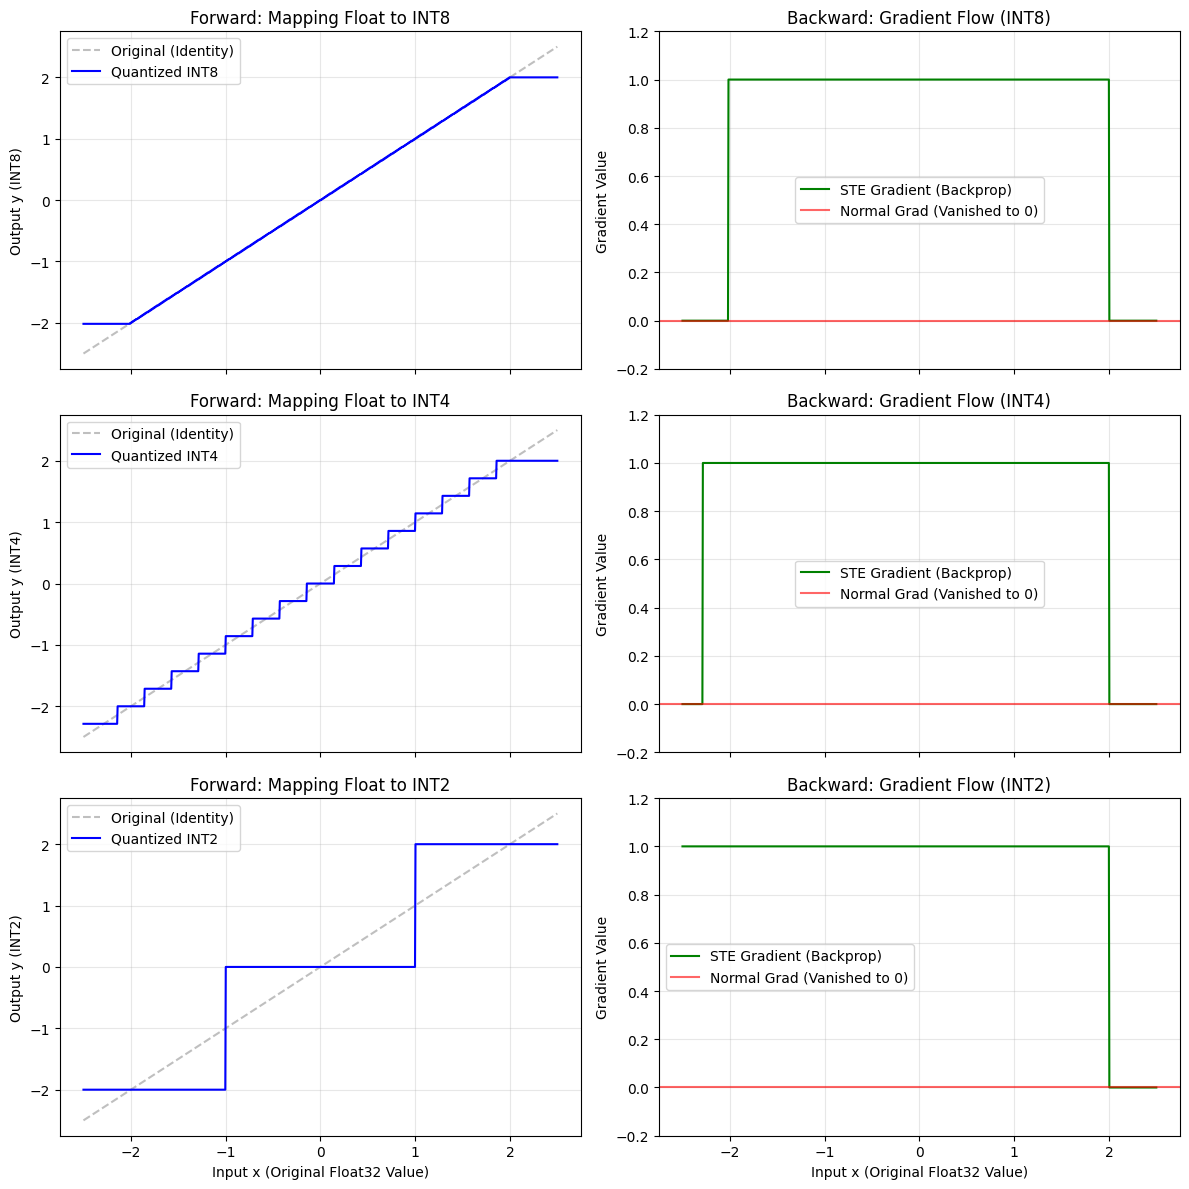

In [ ]:
def visualize_ste_effect(bits_list=[8, 4, 2]):
    x = torch.linspace(-2.5, 2.5, 1000, requires_grad=True)
    
    fig, axes = plt.subplots(len(bits_list), 2, figsize=(12, 12), sharex=True)
    
    for i, bits in enumerate(bits_list):
        qmin = -2**(bits - 1)
        qmax = 2**(bits - 1) - 1
        scale = 2.0 / (2**(bits - 1) - 1)
        
        x_clamped = torch.clamp(x / scale, qmin, qmax)
        x_q = (torch.round(x_clamped) - x_clamped).detach() + x_clamped
        x_dq = x_q * scale
        
        loss = x_dq.sum()
        loss.backward()
        grad_ste = x.grad.clone()
        
        axes[i, 0].plot(x.detach(), x.detach(), '--', color='gray', alpha=0.5, label='Original (Identity)')
        axes[i, 0].plot(x.detach(), x_dq.detach(), color='blue', label=f'Quantized INT{bits}')
        axes[i, 0].set_ylabel(f"Output y (INT{bits})")
        axes[i, 0].set_title(f"Forward: Mapping Float to INT{bits}")
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)

        axes[i, 1].plot(x.detach(), grad_ste, color='green', label='STE Gradient (Backprop)')
        axes[i, 1].axhline(y=0, color='red', linestyle='-', alpha=0.6, label='Normal Grad (Vanished to 0)')
        axes[i, 1].set_ylabel("Gradient Value")
        axes[i, 1].set_title(f"Backward: Gradient Flow (INT{bits})")
        axes[i, 1].set_ylim(-0.2, 1.2)
        axes[i, 1].legend()
        axes[i, 1].grid(True, alpha=0.3)

        x.grad.zero_()

    axes[-1, 0].set_xlabel("Input x (Original Float32 Value)")
    axes[-1, 1].set_xlabel("Input x (Original Float32 Value)")
    
    plt.tight_layout()
    plt.show()

visualize_ste_effect([8, 4, 2])

#### Test

In [ ]:
def test_quantization(num_bits, mode, use_ste, channels=None):
    fq = FakeQuantize(num_bits=num_bits, mode=mode, channels=channels, use_ste=use_ste)
    
    x = torch.randn(1, 3, 2, 2, requires_grad=True)
    output = fq(x)
    loss = output.sum()
    loss.backward()
    
    print(f"Test: {mode} | STE: {use_ste} | Bits: {num_bits}")
    print(f"Input Scale: {fq.scale.flatten().detach().numpy()}")
    
    if x.grad is not None:
        grad_status = "NOT ZERO" if torch.any(x.grad != 0) else "ZERO"
    else:
        grad_status = "Nulo"
    
    print(f"Gradient Status: {grad_status}")
    print(f"dq:{output.flatten()[:4].detach().numpy()}\n")

test_quantization(num_bits=8, mode='per-tensor', use_ste=False)
test_quantization(num_bits=8, mode='per-tensor', use_ste=True)
test_quantization(num_bits=8, mode='per-channel', use_ste=True, channels=3)

Test: per-tensor | STE: False | Bits: 8
Input Scale: [0.01362133]
Gradient Status: ZERO
dq:[-1.062464    0.29966936  0.27242666  1.7299094 ]

Test: per-tensor | STE: True | Bits: 8
Input Scale: [0.01102467]
Gradient Status: NOT ZERO
dq:[ 0.3086906  0.6614799  1.3009105 -0.7276279]

Test: per-channel | STE: True | Bits: 8
Input Scale: [0.01340927 0.01340927 0.01340927]
Gradient Status: NOT ZERO
dq:[0.04022782 0.8984213  1.3543365  1.7029777 ]

